from https://keras.io/examples/generative/vae/

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from progressbar import progressbar as pbar
import matplotlib.pyplot as plt
from rlxutils import subplots
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

2022-01-16 16:26:26.639065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-16 16:26:26.639103: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

2022-01-16 16:26:42.157140: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-16 16:26:42.157181: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-16 16:26:42.157209: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rlxyoga): /proc/driver/nvidia/version does not exist


In [4]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255


# AE and VAE implementations sharing the same architecture

VAE has an extra layer to predict latent distribution std

In [157]:
class Encoder(keras.Model):
    
    def __init__(self, latent_dim=2):
        super().__init__()
        self.conv1_layer = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same", name="conv1")
        self.conv2_layer = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same", name="conv2")
        self.dense_layer = layers.Dense(16, activation="relu", name="dense1")

        self.output_layer = layers.Dense(latent_dim, name="output")

    def call_stage(self, x):
        x = self.conv1_layer(x)
        x = self.conv2_layer(x)
        x = layers.Flatten()(x)
        x = self.dense_layer(x)
        return x
    
    def call(self, x):
        x = self.call_stage(x)
        x = self.output_layer(x)
        return x

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
class VAE_Encoder(Encoder):
    
    def __init__(self, latent_dim=2):
        super().__init__(latent_dim=latent_dim)
        
        self.z_mean_layer    = self.output_layer
        self.z_log_var_layer = layers.Dense(latent_dim, name="z_log_var")
        self.z_sampling_layer = Sampling(name="sampling")

    def call(self, x):
        x = self.call_stage(x)
        z_mean    = self.z_mean_layer(x)
        z_log_var = self.z_log_var_layer(x)
        z_sample  = self.z_sampling_layer([z_mean, z_log_var])
        
        return [z_mean, z_log_var, z_sample]
    
class Decoder(keras.Model):
    
    def __init__(self, latent_dim=2):
        super().__init__()
        self.dense_layer = layers.Dense(7 * 7 * 64, activation="relu", name="dense")
        self.convt1_layer = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same", name="convt1")
        self.convt2_layer = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same", name="convt2")
        self.convt_output_layer = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same", name="convt_output")
        
    def call(self, x):
        x = self.dense_layer(x)
        x = layers.Reshape((7, 7, 64))(x)
        x = self.convt1_layer(x)
        x = self.convt2_layer(x)
        x = self.convt_output_layer(x)
        return x

In [158]:
class VAE(keras.Model):
    def __init__(self, latent_dim=2, **kwargs):
        super().__init__(**kwargs)
        self.encoder = VAE_Encoder(latent_dim=latent_dim)
        self.decoder = Decoder()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        return self.decoder(z)
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [159]:
class AE(keras.Model):
    def __init__(self, latent_dim=2, **kwargs):
        super().__init__(**kwargs)
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder()
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.reconstruction_loss_history = []

    def call(self, x):
        return self.decoder(self.encoder(x))
        
    @property
    def metrics(self):
        return [self.reconstruction_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
        grads = tape.gradient(reconstruction_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.reconstruction_loss_history.append(self.reconstruction_loss_tracker.result())
        return {
            "loss": self.reconstruction_loss_tracker.result()
        }

## train both VAE and AE

In [160]:
from collections import defaultdict

In [161]:
class LogHistoryCallback(keras.callbacks.Callback):
    def __init__(self):
        self.history = defaultdict(lambda: [])
        
    def on_train_batch_end(self, batch, logs=None):
        for k,v in logs.items():
            self.history[k].append(v)        

In [162]:
latent_dim = 2

In [163]:
ae = AE(latent_dim=latent_dim)
ae_history = LogHistoryCallback()
ae.compile(optimizer=keras.optimizers.Adam())
ae.fit(mnist_digits, epochs=10, batch_size=128, callbacks=[ae_history])

Epoch 1/2
547/547 [==============================] - 27s 49ms/step - loss: 255.1408
Epoch 2/2
547/547 [==============================] - 27s 49ms/step - loss: 166.7663


In [164]:
vae = VAE(latent_dim = latent_dim)
vae_history = LogHistoryCallback()
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=10, batch_size=128, callbacks=[vae_history])

Epoch 1/2
547/547 [==============================] - 28s 50ms/step - loss: 257.3496 - reconstruction_loss: 212.2109 - kl_loss: 2.1739
Epoch 2/2
547/547 [==============================] - 27s 49ms/step - loss: 191.1397 - reconstruction_loss: 186.2709 - kl_loss: 3.0532


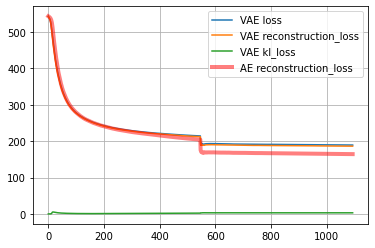

In [165]:
for k,v in vae_history.history.items():
    plt.plot(v, label=f"VAE {k}")

plt.plot(ae_history.history['loss'], label="AE reconstruction_loss", color="red", lw=4, alpha=.5)

plt.legend();
plt.grid();

## Encoder distributions over the full dataset

one chart per `latent_dim`

In [166]:
vaezm,vaezs,vaez = [i.numpy() for i in vae.encoder(mnist_digits)]
aez = ae.encoder(mnist_digits).numpy()

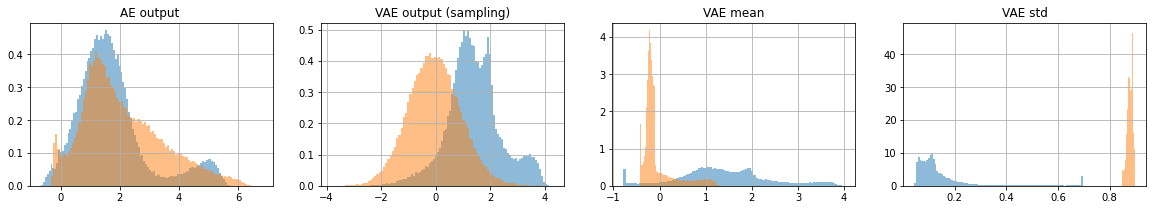

In [167]:
for ax,k in subplots(4, usizex=5):
    if k==0:
        for i in range(latent_dim):
            plt.hist(aez[:,i], density=True, bins=100, alpha=.5);
        plt.title("AE output ")
        plt.grid();
    if k==1:
        for i in range(latent_dim):
            plt.hist(vaez[:,i], density=True, bins=100, alpha=.5);
        plt.title("VAE output (sampling)")
        plt.grid();
    if k==2:
        for i in range(latent_dim):
            plt.hist(vaezm[:,i], density=True, bins=100, alpha=.5);
        plt.title("VAE mean")
        plt.grid();
    if k==3:
        for i in range(latent_dim):
            plt.hist(np.exp(.5*vaezs[:,i]), density=True, bins=100, alpha=.5);
        plt.title("VAE std")
        plt.grid();
        

## Output for a selected input image

- VAE outputs a distribution of images (a distribution per pixel)
- AE outputs a single image (a value per pixel)


In [168]:
# select one random input
idx = np.random.randint(len(mnist_digits))

In [188]:
# AE is deterministic, so we do inference just once and obtain one value for each output pixel
output_ae = ae(mnist_digits[idx:idx+1]).numpy()
output_ae.shape

(1, 28, 28, 1)

In [189]:
# VAE is stochastic, so we do inference many times to understand the output distribution of each pixel
output_vae = vae(np.repeat(mnist_digits[idx:idx+1],10000, axis=0)).numpy()
output_vae.shape

(10000, 28, 28, 1)

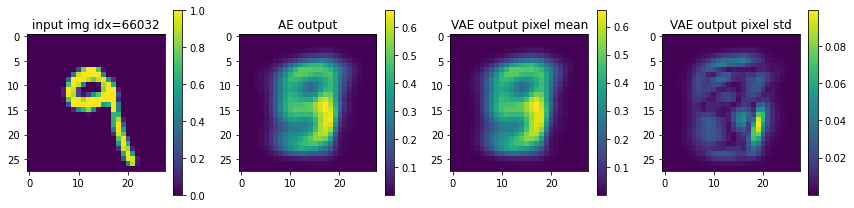

In [190]:
for ax, i in subplots(4):
    if i==0:
        plt.imshow(mnist_digits[idx][:,:,0])
        plt.title(f"input img idx={idx}")
        plt.colorbar();
    if i==1:
        plt.imshow(output_ae[0,:,:,0])
        plt.title("AE output")
        plt.colorbar();        
    if i==2:
        plt.imshow(output_vae[:,:,:,0].mean(axis=0))
        plt.title("VAE output pixel mean")
        plt.colorbar();        
    if i==3:
        plt.imshow(output_vae[:,:,:,0].std(axis=0))
        plt.title("VAE output pixel std")
        plt.colorbar();
plt.tight_layout()

show VAE distribution of pixel with largest mean and largest std

In [191]:
my,mx = output_vae.mean(axis=0).argmax()//28, output_vae.mean(axis=0).argmax()%28
sy,sx = output_vae.std(axis=0).argmax()//28, output_vae.std(axis=0).argmax()%28
ry1,rx1,ry2,rx2 = np.random.randint(28, size=4)

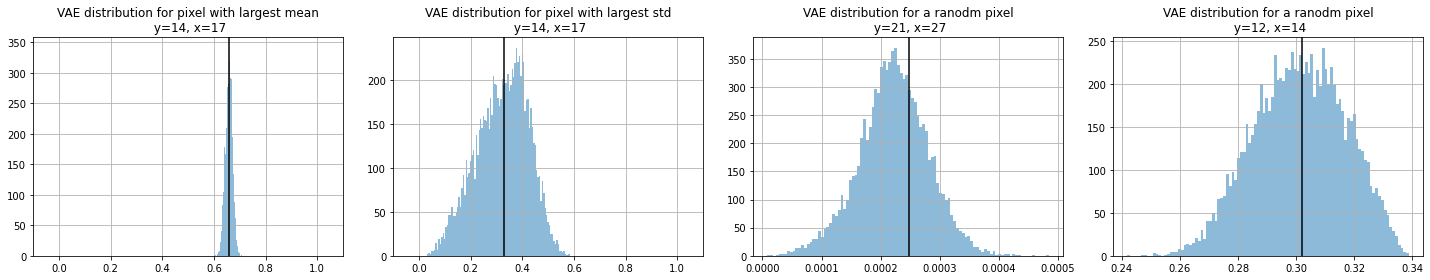

In [192]:
vmin, vmax = output_vae.min(), np.max([output_ae.max(),1])+.1
vmin -= .1
for ax,i in subplots(4, usizex=5, usizey=4):
    if i==0:
        plt.hist(output_vae[:,my,mx,0], bins=100, alpha=.5);
        plt.axvline(output_ae[0,my,mx,0], color="black")
        plt.grid();
        plt.title(f"VAE distribution for pixel with largest mean\n y={my}, x={mx}")
        plt.xlim(vmin, vmax)
    if i==1:
        plt.hist(output_vae[:,sy,sx,0], bins=100, alpha=.5);
        plt.axvline(output_ae[0,sy,sx,0], color="black")
        plt.grid();
        plt.title(f"VAE distribution for pixel with largest std\n y={my}, x={mx}")
        plt.xlim(vmin, vmax)
    if i==2:
        plt.hist(output_vae[:,ry1,rx1,0], bins=100, alpha=.5);
        plt.axvline(output_ae[0,ry1,rx1,0], color="black")
        plt.grid();
        plt.title(f"VAE distribution for a ranodm pixel\n y={ry1}, x={rx1}")
    if i==3:
        plt.hist(output_vae[:,ry2,rx2,0], bins=100, alpha=.5);
        plt.grid();
        plt.title(f"VAE distribution for a ranodm pixel\n y={ry2}, x={rx2}")
        plt.axvline(output_ae[0,ry2,rx2,0], color="black")
plt.tight_layout()

In [176]:
[i.name for i in vae.decoder.layers]

['dense', 'convt1', 'convt2', 'convt_output']

In [177]:
[i.name for i in ae.decoder.layers]

['dense', 'convt1', 'convt2', 'convt_output']

In [185]:
def transfer_weights(from_model, to_model):
    layers_not_transferred = []
    layers_transferred = []
    for from_layer in from_model.layers:
        try:
            to_layer = to_model.get_layer(from_layer.name)
            from_w = from_layer.get_weights()
            to_w   = to_layer.get_weights()
            if len(from_w)==len(to_w) and np.alltrue([f.shape==t.shape for f,t in zip(from_w, to_w)]):
                to_layer.set_weights(from_w)
                layers_transferred.append(from_layer.name)            
            else:
                layers_not_transferred.append(from_layer.name)            
        except:
            layers_not_transferred.append(from_layer.name)
            continue
    
    print ("layers transferred    ", layers_transferred)
    print ("layers not transferred", layers_not_transferred)

In [186]:
transfer_weights(vae.encoder, ae.encoder)

layers transferred     ['conv1', 'conv2', 'dense1', 'output']
layers not transferred ['z_log_var', 'sampling']


In [187]:
transfer_weights(vae.decoder, ae.decoder)

layers transferred     ['dense', 'convt1', 'convt2', 'convt_output']
layers not transferred []
